In [1]:
from datetime import datetime, timedelta
from pathlib import Path

import requests
import numpy as np
import rasterio as rio
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.warp import reproject, Resampling

In [ ]:
GDD_ROOT_URL = "https://agriculture.canada.ca/atlas/data_donnees/agClimate/data_donnees/tif/gd/"
GDD_BASE = "10/"
GDD_URL = f"{GDD_ROOT_URL}{GDD_BASE}"

TENSOR_DIR = Path("datasets/sentinel")

In [3]:
def get_crop(filename):
    return filename.split('_')[0]

def get_yeardate(filename):
    return filename.split('_')[2]

def get_year(filename):
    return get_yeardate(filename)[0:4]

def get_date(filename):
    return get_yeardate(filename)[4:]

def get_filename(path):
    return path.stem

def get_bbox(raster):
    with rio.open(raster) as src:
        return src.bounds
    
def get_crs(raster):
    with rio.open(raster) as src:
        return src.crs
    
def get_yeardate_gdd(filename):
    return filename.split('_')[2].split('.')[0]    

In [4]:
tensors = list(TENSOR_DIR.glob("*.tif"))

In [5]:
def match_raster_and_mask(input_path, reference_path, output_path=None, resampling_method=Resampling.bilinear):
    with rio.open(reference_path) as ref:
        ref_crs = ref.crs
        ref_transform = ref.transform
        ref_width, ref_height = ref.width, ref.height
        mask_data = ref.read(1)
        mask_nodata = ref.nodata if ref.nodata is not None else 0


    with rio.open(input_path) as src:

        # Update metadata
        new_meta = src.meta.copy()
        new_meta.update({
            "crs": ref_crs,
            "transform": ref_transform,
            "width": ref_width,
            "height": ref_height,
            # Use 0 as nodata for integer types
            # and the mask nodata value for float32
            "nodata": mask_nodata if src.dtypes[0] == 'float32' else 0
        })

        # Use in-memory file if no output path is given
        if output_path is None:
            memfile = MemoryFile()
            output = memfile.open(**new_meta)
        else:
            memfile = None
            output = rio.open(output_path, "w", **new_meta)

        with output as dst:
            for i in range(1, src.count + 1):
                band_data = np.zeros((ref_height, ref_width), dtype=src.dtypes[i - 1])
                reproject(
                    source=rio.band(src, i),
                    destination=band_data,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=ref_transform,
                    dst_crs=ref_crs,
                    resampling=resampling_method
                )

                # Apply mask
                band_data = np.where(np.isclose(mask_data, mask_nodata), mask_nodata, band_data)

                # Write to output
                dst.write(band_data, i)

        return memfile if memfile else output_path

In [7]:
def add_layer_to_geotiff(input_path, new_band_data, output_path):
    # Open and retrieve the new band data
    with rio.open(new_band_data) as data:
        new_band_data = data.read(1)
    
    with rio.open(input_path) as src:
        # Get the existing metadata (CRS, transform, etc.)
        meta = src.meta.copy()

        # Check if the new band data matches the shape of the existing data
        if (data.height, data.width) != (src.height, src.width):
            raise ValueError("New band data shape does not match the existing raster dimensions.")
        
        # Check data type
        if new_band_data.dtype != src.dtypes[0]:
            raise ValueError("New band data type does not match the existing raster data type.")

        # Update the number of bands to reflect the new band
        meta.update(count=src.count + 1)

        # Open the output GeoTIFF to write the data
        with rio.open(output_path, 'w', **meta) as dst:
            # Write all existing bands to the new file
            for i in range(1, src.count + 1):
                dst.write(src.read(i), i)

            # Write the new band as the last band
            dst.write(new_band_data, src.count + 1)

In [8]:
# Get a list of GDD tifs from the server
response = requests.get(GDD_URL)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Find all the links in the directory listing
links = soup.find_all('a')

# Extract the href attributes of the links
files = [link.get('href') for link in links if link.get('href').endswith('.tif')]

# Filter files for years 2016-2023
# Format of the files is crop_yeardate.tif
# where yeardate is the yyyymmdd format
filtered_files = []
for file in files:
    yeardate = get_yeardate_gdd(file)
    yeardate = datetime.strptime(yeardate, '%Y%m%d')
    if yeardate.year >= 2016 and yeardate.year <= 2023:
        filtered_files.append(file)

# Download the files to /gdd_10
# Check for dir and create if it doesn't exist
gdd_dir = Path("data/gdd_10")
gdd_dir.mkdir(parents=True, exist_ok=True)

for file in filtered_files:
    file_path = gdd_dir / file
    if file_path.exists():
        print(f"File {file} already exists, skipping download.")
        continue
    url = f"{GDD_URL}{file}"
    response = requests.get(url)
    with open(file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=None):
            f.write(response.content)

File gd_10_20160404.tif already exists, skipping download.
File gd_10_20160411.tif already exists, skipping download.
File gd_10_20160418.tif already exists, skipping download.
File gd_10_20160425.tif already exists, skipping download.
File gd_10_20160430.tif already exists, skipping download.
File gd_10_20160502.tif already exists, skipping download.
File gd_10_20160509.tif already exists, skipping download.
File gd_10_20160516.tif already exists, skipping download.
File gd_10_20160523.tif already exists, skipping download.
File gd_10_20160530.tif already exists, skipping download.
File gd_10_20160531.tif already exists, skipping download.
File gd_10_20160606.tif already exists, skipping download.
File gd_10_20160613.tif already exists, skipping download.
File gd_10_20160620.tif already exists, skipping download.
File gd_10_20160627.tif already exists, skipping download.
File gd_10_20160630.tif already exists, skipping download.
File gd_10_20160704.tif already exists, skipping downloa

In [9]:
gdd_dir = Path("data/gdd_10")

In [10]:
for tensor in tensors:
    year = get_year(get_filename(tensor))
    date = get_date(get_filename(tensor))

    print(f'Processing {tensor.stem} from {year} {date}')

    harvest_date = datetime.strptime(f'{year} {date}', '%Y %j')
    begin_search_date = harvest_date - timedelta(days=28)
    # Looks like some harvest dates might, be off, to be safe, we end the search
    # a few days before the harvest date
    end_search_date = harvest_date - timedelta(days=3)

    # Look through the sorted list of GDD files
    # and find the most recenet one that is within the search date range
    gdd_files = sorted(gdd_dir.glob('*.tif'), reverse=True)
    gdd_file_candidate = None
    for gdd_file in gdd_files:
        yeardate = get_yeardate_gdd(gdd_file.stem)
        yeardate = datetime.strptime(yeardate, '%Y%m%d')
        if yeardate >= begin_search_date and yeardate <= end_search_date:
            gdd_file_candidate = gdd_file
            break

    if gdd_file_candidate is None:
        print(f'No GDD file found for {tensor.stem}')
        continue

    # Match the raster and mask
    matched_raster = match_raster_and_mask(gdd_file_candidate, tensor)

    # check for the gdd ouput dir and create if it doesn't exist
    gdd_output_dir = Path("gdd")
    gdd_output_dir.mkdir(parents=True, exist_ok=True)

    # Stack the matched raster and mask
    output_path = Path(f'{gdd_output_dir}/{tensor.stem}.tif')
    add_layer_to_geotiff(tensor, matched_raster, output_path)

    # Clean up
    matched_raster.close()

    print(f'Processed {tensor.stem} from {year} {date}')
    

Processing CANOLA_02038a28-b22b-49ea-aa2b-7d12df8899be_2020255 from 2020 255
Processed CANOLA_02038a28-b22b-49ea-aa2b-7d12df8899be_2020255 from 2020 255
Processing CANOLA_09b11302-014d-4512-b3fc-9253b7b9ebdf_2018236 from 2018 236
Processed CANOLA_09b11302-014d-4512-b3fc-9253b7b9ebdf_2018236 from 2018 236
Processing CANOLA_09b11302-014d-4512-b3fc-9253b7b9ebdf_2020242 from 2020 242
Processed CANOLA_09b11302-014d-4512-b3fc-9253b7b9ebdf_2020242 from 2020 242
Processing CANOLA_18c90f81-79f3-494c-97a2-5a3475029d4f_2017248 from 2017 248
Processed CANOLA_18c90f81-79f3-494c-97a2-5a3475029d4f_2017248 from 2017 248
Processing CANOLA_18c90f81-79f3-494c-97a2-5a3475029d4f_2021257 from 2021 257
Processed CANOLA_18c90f81-79f3-494c-97a2-5a3475029d4f_2021257 from 2021 257
Processing CANOLA_19d20121-96cb-48e2-bbd8-809387352951_2017237 from 2017 237
Processed CANOLA_19d20121-96cb-48e2-bbd8-809387352951_2017237 from 2017 237
Processing CANOLA_1a3e0bf5-44df-4b8e-b56f-7ae25295147f_2018227 from 2018 227
Proce

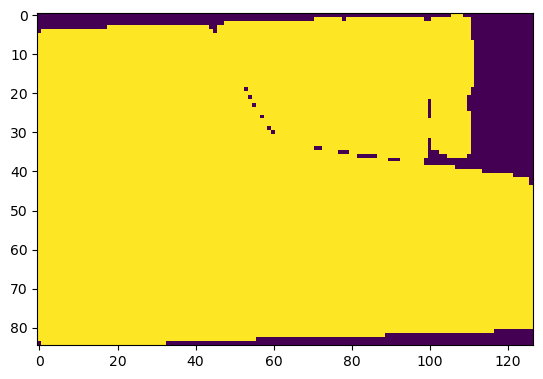

[-999.     1223.2799]


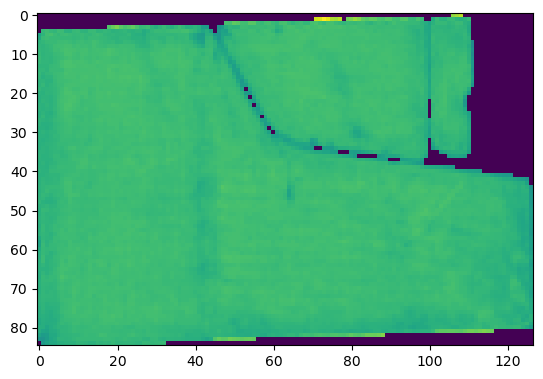

In [12]:
tensor = tensors[0]
gdd = gdd_files[0]

memfile = match_raster_and_mask(gdd, tensor, resampling_method=Resampling.nearest)

# Plot the matched raster
with rio.open(memfile) as src:
    fig, ax = plt.subplots()
    ax.imshow(src.read(1), cmap='viridis')
    plt.show()
    print(np.unique(src.read(1)))

# Plot the tensor

with rio.open(tensor) as src:
    fig, ax = plt.subplots()
    ax.imshow(src.read(1), cmap='viridis')
    plt.show()

